In [197]:
# ライブラリの読み込み
import json
import pickle
import random
import re
import statistics

import japanize_matplotlib

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from pprint import pprint
from sklearn.metrics import mean_absolute_error
from tqdm.auto import tqdm

In [2]:
# 設定
plt.rcParams["font.family"] = "IPAexGothic"

pd.options.display.max_columns = 200
pd.options.display.max_rows = 100

In [6]:
# データの読み込み
df_result = pd.read_csv("human0821.csv")
df_gt = pd.read_csv("all_data.csv", index_col=0)
df_t = df_gt.T
selected_ids = list(set(df_result["target_ID"]))
df_drop = df_gt.drop(selected_ids, axis=0)
df_train = pd.read_csv("train.csv", index_col=0).T
df_test = pd.read_csv("test.csv", index_col=0)

In [4]:
# 重みの読み込み
matrix_dict = {}

for dim in tqdm(range(5, 30)):
    matrix_dict[dim] = [
        np.load(f"nmf_w/train/nmf_w_r{i}/nmf_50000_w_{dim}_r{i}.npy") for i in range(1000)
    ]

  0%|          | 0/25 [00:00<?, ?it/s]

In [77]:
# 推論
def calculate_score(target_id: int, selected_images: list, dims: tuple):
    result = {}
    q_gt = df_gt.iloc[target_id].to_numpy()
    x = df_gt.iloc[target_id, selected_images].to_numpy()

    for dim in dims:
        q_array = []
        result[dim] = {}
        for random_state in range(1000):
            W = matrix_dict[dim][random_state]
            W1 = W[selected_images]
            W1_inv = np.linalg.pinv(W1)
            h_est = np.dot(W1_inv, x)
            q = np.dot(W, h_est)
            q[q<0] = 0
            q[q>10] = 10
            q_array.append(q)
        q = sum(q_array) / len(q_array)
        result[dim]["q"] = q
        result[dim]["MAE"] = mean_absolute_error(q, q_gt)
    return result

In [25]:
# 次元
dims = (5, 10, 15)

In [17]:
# 訓練用データの分散
variances = df_train.var()
# 分散が大きい順に列をソート
sorted_columns = variances.sort_values(ascending=False).index.to_list()

In [31]:
# 列名をimage_idに変換
def find_index(col_name):
    pattern = r"No\.(\d+)"
    match = re.search(pattern, col_name)

    if match:
        return int(match.group(1))-1
    else:
        return -1

(array([ 2.,  0.,  3.,  7., 15., 23., 26., 13.,  9.,  2.]),
 array([2.4382169 , 2.99259293, 3.54696895, 4.10134497, 4.65572099,
        5.21009701, 5.76447303, 6.31884905, 6.87322508, 7.4276011 ,
        7.98197712]),
 <BarContainer object of 10 artists>)

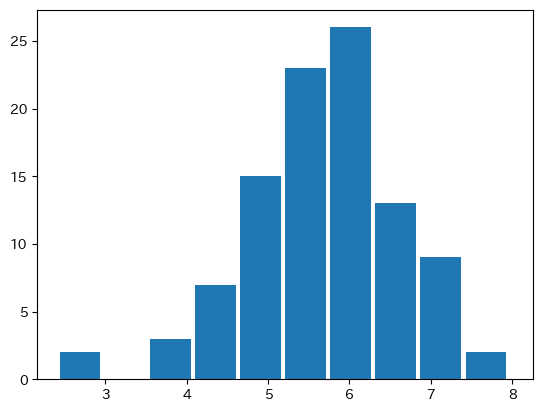

In [41]:
plt.hist(variances, width=0.5)

In [78]:
# 分散が大きい順に10枚聞く
var_large_10 = sorted([find_index(col_name) for col_name in sorted_columns[:10]])
print(var_large_10)
var_large_10_results = []
for index, row in tqdm(df_test.iterrows()):
    result = calculate_score(row.name, var_large_10, dims)
    var_large_10_results.append(result)

# 分散が小さい順に10枚聞く
var_small_10 = sorted([find_index(col_name) for col_name in sorted_columns[-10:]])
print(var_small_10)
var_small_10_results = []
for index, row in tqdm(df_test.iterrows()):
    result = calculate_score(row.name, var_small_10, dims)
    var_small_10_results.append(result)

# 分散が大きい順に5枚、小さい順に5枚聞く
var_large_5_small_5 = sorted([find_index(col_name) for col_name in sorted_columns[-5:]] + [find_index(col_name) for col_name in sorted_columns[:5]])
var_large_5_small_5_results = []
print(var_large_5_small_5)
for index, row in tqdm(df_test.iterrows()):
    result = calculate_score(row.name, var_large_5_small_5, dims)
    var_large_5_small_5_results.append(result)

MAE_var_large_10 = {5: [], 10: [], 15: []}
for result in var_large_10_results:
    for dim in dims:
        MAE_var_large_10[dim].append(result[dim]["MAE"])

MAE_var_small_10 = {5: [], 10: [], 15: []}
for result in var_small_10_results:
    for dim in dims:
        MAE_var_small_10[dim].append(result[dim]["MAE"])

MAE_var_large_5_small_5 = {5: [], 10: [], 15: []}
for result in var_large_5_small_5_results:
    for dim in dims:
        MAE_var_large_5_small_5[dim].append(result[dim]["MAE"])

[2, 3, 6, 12, 29, 32, 53, 63, 64, 97]


0it [00:00, ?it/s]

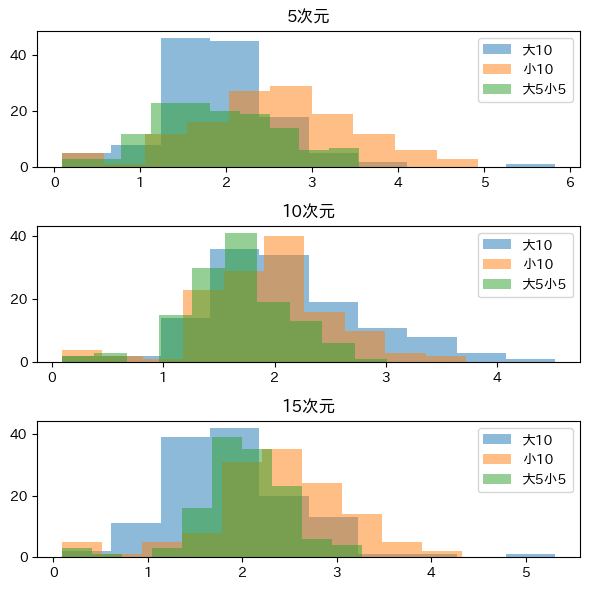

In [89]:
plt.rcParams["figure.figsize"] = (6, 6)
for index, dim in enumerate(dims):
    plt.subplot(3, 1, index+1)
    plt.hist(MAE_var_large_10[dim], label="大10", alpha=0.5)
    plt.hist(MAE_var_small_10[dim], label="小10", alpha=0.5)
    plt.hist(MAE_var_large_5_small_5[dim], label="大5小5", alpha=0.5)
    plt.title(f"{dim}次元")
    plt.legend()

plt.tight_layout()

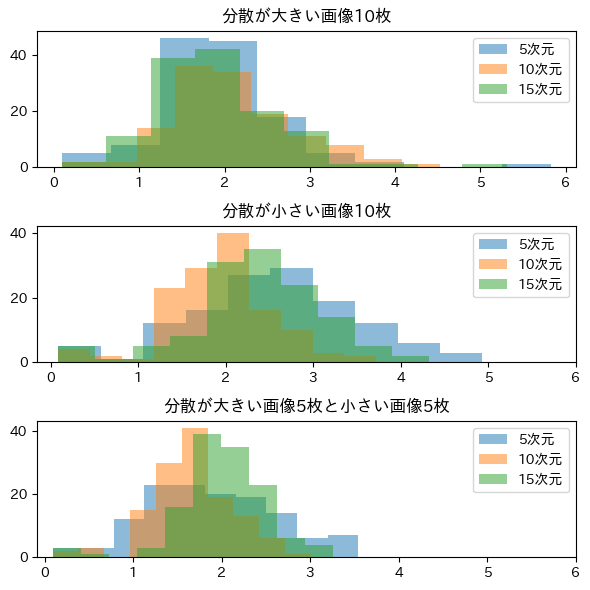

In [87]:
plt.rcParams["figure.figsize"] = (6, 6)
plt.subplot(3, 1, 1)
for index, dim in enumerate(dims):
    plt.hist(MAE_var_large_10[dim], label=f"{dim}次元", alpha=0.5)
    plt.title("分散が大きい画像10枚")
    plt.xticks(list(range(7)))
    plt.legend()

plt.subplot(3, 1, 2)
for index, dim in enumerate(dims):
    plt.hist(MAE_var_small_10[dim], label=f"{dim}次元", alpha=0.5)
    plt.title("分散が小さい画像10枚")
    plt.xticks(list(range(7)))
    plt.legend()

plt.subplot(3, 1, 3)
for index, dim in enumerate(dims):
    plt.hist(MAE_var_large_5_small_5[dim], label=f"{dim}次元", alpha=0.5)
    plt.title("分散が大きい画像5枚と小さい画像5枚")
    plt.xticks(list(range(7)))
    plt.legend()
plt.tight_layout()

In [189]:
df_MAE_var_large_10 = pd.DataFrame({'5次元':MAE_var_large_10[5],'10次元':MAE_var_large_10[10],'15次元':MAE_var_large_10[15]})
df_MAE_var_large_10.describe()

,5次元,10次元,15次元
count,130.000000,130.000000,130.000000
mean,1.933468,2.074104,1.888936
std,0.740325,0.727399,0.714834
min,0.090000,0.090000,0.090000
25%,1.494254,1.567586,1.423096
50%,1.898306,1.974107,1.810688
75%,2.241910,2.465617,2.226946
max,5.829612,4.521380,5.312137


In [192]:
df_MAE_var_small_10 = pd.DataFrame({'5次元':MAE_var_small_10[5],'10次元':MAE_var_small_10[10],'15次元':MAE_var_small_10[15]})
df_MAE_var_small_10.describe()

,5次元,10次元,15次元
count,130.000000,130.000000,130.000000
mean,2.568446,1.930631,2.371232
std,0.945780,0.603226,0.735406
min,0.090000,0.090000,0.090000
25%,1.991436,1.570062,2.014630
50%,2.624029,1.938512,2.409793
75%,3.196585,2.233780,2.712782
max,4.935494,3.720000,4.324099


In [191]:
df_MAE_var_large_5_small_5 = pd.DataFrame({'5次元':MAE_var_large_5_small_5[5],'10次元':MAE_var_large_5_small_5[10],'15次元':MAE_var_large_5_small_5[15]})
df_MAE_var_large_5_small_5.describe()

,5次元,10次元,15次元
count,130.000000,130.000000,130.000000
mean,1.886614,1.661007,2.007800
std,0.722917,0.469135,0.495332
min,0.090000,0.090000,0.090000
25%,1.396747,1.390516,1.752011
50%,1.829376,1.656175,2.019443
75%,2.371965,1.915255,2.318713
max,3.542538,3.010666,3.263769


In [141]:
df_train_corr = df_train.corr()

In [142]:
print(sorted_columns[0])
var_max_col = df_train_corr[sorted_columns[0]]
var_max_col.nlargest(2).iloc[-1]
var_max_col[var_max_col == var_max_col.nlargest(2).iloc[-1]].index[0]

No.65の画像があなたの好みであるかを0から10で評価してください．


'No.66の画像があなたの好みであるかを0から10で評価してください．'

In [175]:
# 分散が大きいものとそれと相関が強いもの

var_corr_max = []
current_index = 0
n_largest = 2
while len(var_corr_max) < 10:
    if len(var_corr_max) % 2 == 0:
        col_name = sorted_columns[current_index]
        if col_name not in var_corr_max:
            var_corr_max.append(col_name)
        current_index += 1
    else:
        raw = df_train_corr[var_corr_max[-1]]
        n_largest_index = raw[raw == raw.nlargest(n_largest).iloc[-1]].index[0]
        if n_largest_index not in var_corr_max:
            var_corr_max.append(n_largest_index)
            n_largest = 2
        else:
            n_largest += 1

var_corr_max_ids = sorted([find_index(col_name) for col_name in var_corr_max])

var_corr_max_results = []

for index, row in tqdm(df_test.iterrows()):
    result = calculate_score(row.name, var_corr_max_ids, dims)
    var_corr_max_results.append(result)

0it [00:00, ?it/s]

In [176]:
# 分散が大きいものとそれと相関が弱いもの

var_corr_zero = []
current_index = 0
n_smallest = 1
while len(var_corr_zero) < 10:
    if len(var_corr_zero)%2==0:
        col_name = sorted_columns[current_index]
        if col_name not in var_corr_zero:
            var_corr_zero.append(col_name)
            current_index += 1
    else:
        raw = df_train_corr[var_corr_zero[-1]]
        n_smallest_index = raw[raw == raw.nsmallest(n_smallest).iloc[-1]].index[0]
        if n_smallest_index not in var_corr_zero:
            var_corr_zero.append(n_smallest_index)
            n_smallest = 1
        else:
            n_smallest += 1

var_corr_zero_ids = sorted([find_index(col_name) for col_name in var_corr_zero])
var_corr_zero_results = []

for index, row in tqdm(df_test.iterrows()):
    result = calculate_score(row.name, var_corr_zero_ids, dims)
    var_corr_zero_results.append(result)

0it [00:00, ?it/s]

In [179]:
MAE_var_corr_max = {5: [], 10: [], 15: []}
for result in var_corr_max_results:
    for dim in dims:
        MAE_var_corr_max[dim].append(result[dim]["MAE"])

MAE_var_corr_zero = {5: [], 10: [], 15: []}
for result in var_corr_zero_results:
    for dim in dims:
        MAE_var_corr_zero[dim].append(result[dim]["MAE"])

In [193]:
df_MAE_var_corr_max = pd.DataFrame({'5次元':MAE_var_corr_max[5],'10次元':MAE_var_corr_max[10],'15次元':MAE_var_corr_max[15]})
df_MAE_var_corr_max.describe()

,5次元,10次元,15次元
count,130.000000,130.000000,130.000000
mean,2.046837,2.134556,2.148789
std,0.844407,0.818809,0.790569
min,0.090000,0.090000,0.090000
25%,1.479418,1.605749,1.663467
50%,1.884296,1.956719,2.034898
75%,2.590626,2.514268,2.627991
max,4.590810,5.134932,5.237612


In [194]:
df_MAE_var_corr_zero = pd.DataFrame({'5次元':MAE_var_corr_zero[5],'10次元':MAE_var_corr_zero[10],'15次元':MAE_var_corr_zero[15]})
df_MAE_var_corr_zero.describe()

,5次元,10次元,15次元
count,130.000000,130.000000,130.000000
mean,1.853596,2.239882,2.050929
std,0.645549,0.908939,0.715502
min,0.335001,0.908616,0.523554
25%,1.391104,1.556276,1.523548
50%,1.859707,2.007308,1.952726
75%,2.241435,2.812282,2.441179
max,4.619769,4.530729,4.849464


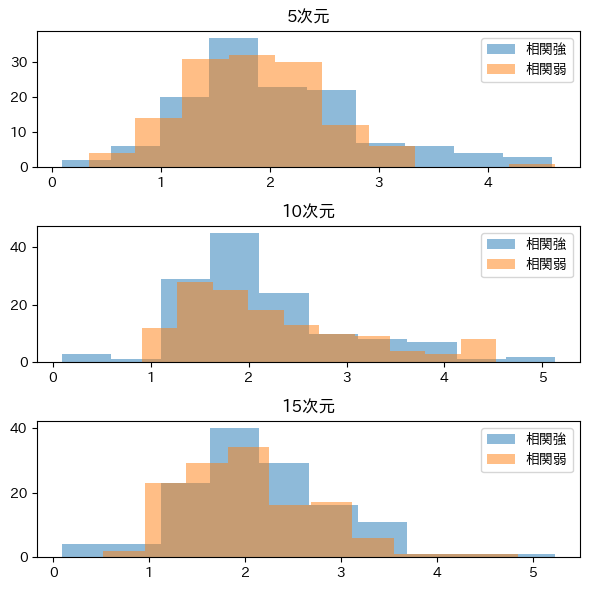

In [211]:
plt.rcParams["figure.figsize"] = (6, 6)
for index, dim in enumerate(dims):
    plt.subplot(3, 1, index+1)
    plt.hist(MAE_var_corr_max[dim], label="相関強", alpha=0.5)
    plt.hist(MAE_var_corr_zero[dim], label="相関弱", alpha=0.5)
    plt.title(f"{dim}次元")
    plt.legend()

plt.tight_layout()

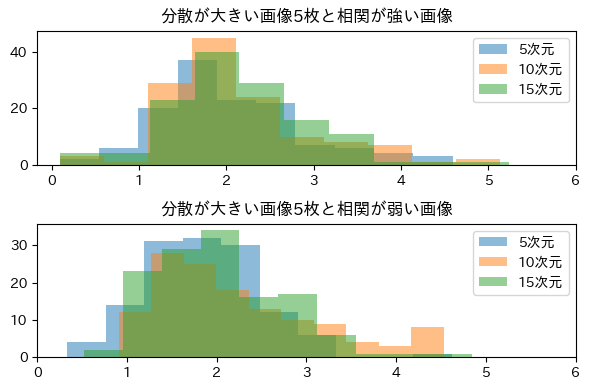

In [183]:
plt.rcParams["figure.figsize"] = (6, 4)
plt.subplot(2, 1, 1)
for index, dim in enumerate(dims):
    plt.hist(MAE_var_corr_max[dim], label=f"{dim}次元", alpha=0.5)
    plt.title("分散が大きい画像5枚と相関が強い画像")
    plt.xticks(list(range(7)))
    plt.legend()

plt.subplot(2, 1, 2)
for index, dim in enumerate(dims):
    plt.hist(MAE_var_corr_zero[dim], label=f"{dim}次元", alpha=0.5)
    plt.title("分散が大きい画像5枚と相関が弱い画像")
    plt.xticks(list(range(7)))
    plt.legend()

plt.tight_layout()

In [186]:
#オブジェクトの呼び出し(sample_object を保存する)
with open('random_samples.pkl', mode='rb') as f:
    random_samples = pickle.load(f)

In [187]:
# ランダム
random_results_0_10 = []

for index, row in tqdm(df_test.iterrows()):
    print(row.name)
    for random_sample in random_samples:
        result = calculate_score(row.name, random_sample, dims)
        random_results_0_10.append(result)

with open(f"random_results_0_10.pkl", "wb") as file:
    pickle.dump(random_results, file)

0it [00:00, ?it/s]

0
1
2
3
5
7
16
19
21
22
30
31
34
41
47
49
52
55
62
77
78
80
84
85
87
89
94
95
100
103
108
111
117
119
121
122
123
124
133
135
136
146
148
153
160
172
180
185
187
197
208
210
220
227
232
254
258
260
267
268
275
278
284
290
292
295
298
312
324
333
342
343
350
363
372
378
381
383
390
394
396
397
406
415
416
419
431
434
440
441
444
445
446
448
457
461
486
488
489
490
492
493
498
504
507
510
524
527
543
546
559
565
576
583
595
597
598
600
608


KeyboardInterrupt: 

In [263]:
# 分散が大きいものとそれと相関が強いもの

var_corr_max_6 = []
current_index = 0
n_largest = 2
while len(var_corr_max) < 10:
    if len(var_corr_max) % 2 == 0:
        col_name = sorted_columns[current_index]
        if col_name not in var_corr_max_6:
            var_corr_max.append(col_name)
        current_index += 1
    else:
        raw = df_train_corr[var_corr_max_6[-1]]
        n_largest_index = raw[raw == raw.nlargest(n_largest).iloc[-1]].index[0]
        if n_largest_index not in var_corr_max_6:
            var_corr_max_6.append(n_largest_index)
            n_largest = 2
        else:
            n_largest += 1

var_corr_max_6_ids = sorted([find_index(col_name) for col_name in var_corr_max_6])

var_corr_max_6_results = []


for index, row in tqdm(df_test.iterrows()):
    result = calculate_score(row.name, var_corr_max_6_ids, dims)
    var_corr_max_6_results.append(result)

# 分散が大きいものとそれと相関が弱いもの
var_corr_zero_6 = []
current_index = 0
n_smallest = 1
while len(var_corr_zero_6) < 6:
    if len(var_corr_zero_6)%2==0:
        col_name = sorted_columns[current_index]
        if col_name not in var_corr_zero_6:
            var_corr_zero_6.append(col_name)
            current_index += 1
    else:
        row = df_train_corr[var_corr_zero_6[-1]]
        n_smallest_index = row[row == row.nsmallest(n_smallest).iloc[-1]].index[0]
        if n_smallest_index not in var_corr_zero_6:
            var_corr_zero_6.append(n_smallest_index)
            n_smallest = 1
        else:
            n_smallest += 1

var_corr_zero_6_ids = sorted([find_index(col_name) for col_name in var_corr_zero_6])
var_corr_zero_6_results = []

for index, row in tqdm(df_test.iterrows()):
    result = calculate_score(row.name, var_corr_zero_6_ids, dims)
    var_corr_zero_6_results.append(result)


MAE_var_corr_max_6 = {5: [], 10: [], 15: []}
for result in var_corr_max_6_results:
    for dim in dims:
        MAE_var_corr_max_6[dim].append(result[dim]["MAE"])

MAE_var_corr_zero_6 = {5: [], 10: [], 15: []}
for result in var_corr_zero_6_results:
    for dim in dims:
        MAE_var_corr_zero_6[dim].append(result[dim]["MAE"])

0it [00:00, ?it/s]

0it [00:00, ?it/s]

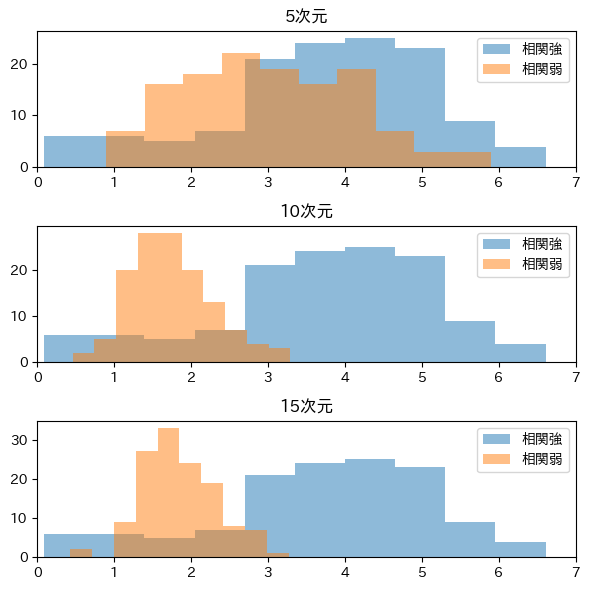

In [264]:
plt.rcParams["figure.figsize"] = (6, 6)
for index, dim in enumerate(dims):
    plt.subplot(3, 1, index+1)
    plt.hist(MAE_var_corr_max_6[dim], label="相関強", alpha=0.5)
    plt.hist(MAE_var_corr_zero_6[dim], label="相関弱", alpha=0.5)
    plt.title(f"{dim}次元")
    plt.legend()
    plt.xlim(0, 7)

plt.tight_layout()

In [206]:
var_corr_zero_6_index = [find_index(col_name) for col_name in sorted_columns[:6]]

with open("filename_list.json", "r") as file:
    data = json.load(file)
    var_corr_zero_6_file_name = [data[index] for index in var_corr_zero_6_index]

In [209]:
with open("sample_var_corr_zero_6.json", "w") as file:
    json.dump(var_corr_zero_6_file_name, file)

In [212]:
# 分散が大きい順に6枚聞く
var_large_6 = sorted([find_index(col_name) for col_name in sorted_columns[:6]])
print(var_large_6)
var_large_6_results = []
for index, row in tqdm(df_test.iterrows()):
    result = calculate_score(row.name, var_large_6, dims)
    var_large_6_results.append(result)

# 分散が小さい順に6枚聞く
var_small_6 = sorted([find_index(col_name) for col_name in sorted_columns[-6:]])
print(var_small_6)
var_small_6_results = []
for index, row in tqdm(df_test.iterrows()):
    result = calculate_score(row.name, var_small_6, dims)
    var_small_6_results.append(result)

# 分散が大きい順に3枚、小さい順に3枚聞く
var_large_3_small_3 = sorted([find_index(col_name) for col_name in sorted_columns[-3:]] + [find_index(col_name) for col_name in sorted_columns[:3]])
var_large_3_small_3_results = []
print(var_large_3_small_3)
for index, row in tqdm(df_test.iterrows()):
    result = calculate_score(row.name, var_large_3_small_3, dims)
    var_large_3_small_3_results.append(result)

MAE_var_large_6 = {5: [], 10: [], 15: []}
for result in var_large_6_results:
    for dim in dims:
        MAE_var_large_6[dim].append(result[dim]["MAE"])

MAE_var_small_6 = {5: [], 10: [], 15: []}
for result in var_small_6_results:
    for dim in dims:
        MAE_var_small_6[dim].append(result[dim]["MAE"])

MAE_var_large_3_small_3 = {5: [], 10: [], 15: []}
for result in var_large_3_small_3_results:
    for dim in dims:
        MAE_var_large_3_small_3[dim].append(result[dim]["MAE"])

[2, 3, 6, 32, 53, 64]


0it [00:00, ?it/s]

[40, 41, 54, 73, 83, 98]


0it [00:00, ?it/s]

[2, 6, 40, 64, 73, 98]


0it [00:00, ?it/s]

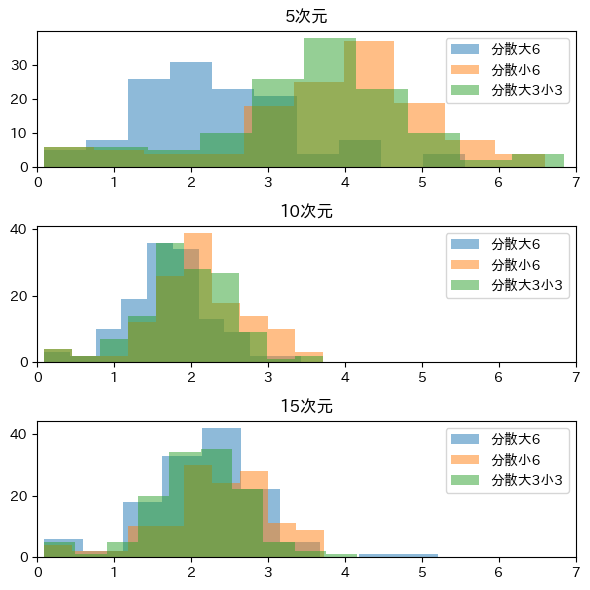

In [221]:
plt.rcParams["figure.figsize"] = (6, 6)
for index, dim in enumerate(dims):
    plt.subplot(3, 1, index+1)
    plt.hist(MAE_var_large_6[dim], label="分散大6", alpha=0.5)
    plt.hist(MAE_var_small_6[dim], label="分散小6", alpha=0.5)
    plt.hist(MAE_var_large_3_small_3[dim], label="分散大3小3", alpha=0.5)
    plt.title(f"{dim}次元")
    plt.xlim(0, 7)
    plt.legend()

plt.tight_layout()

In [259]:
df_var_large_6 = pd.DataFrame({'5次元':MAE_var_large_6[5],'10次元':MAE_var_large_6[10],'15次元':MAE_var_large_6[15]})
df_var_large_6.describe()

,5次元,10次元,15次元
count,130.000000,130.000000,130.000000
mean,2.337013,1.711770,2.169776
std,1.038470,0.541312,0.764682
min,0.090000,0.090000,0.090000
25%,1.632197,1.406131,1.704973
50%,2.122242,1.674630,2.213737
75%,2.913844,2.019226,2.584988
max,5.558814,3.435423,5.205698


In [260]:
df_var_small_6 = pd.DataFrame({'5次元':MAE_var_small_6[5],'10次元':MAE_var_small_6[10],'15次元':MAE_var_small_6[15]})
df_var_small_6.describe()

,5次元,10次元,15次元
count,130.000000,130.000000,130.000000
mean,3.814556,2.100465,2.319317
std,1.333294,0.679881,0.739280
min,0.090000,0.090000,0.090000
25%,3.227631,1.711038,1.989860
50%,4.059420,2.095741,2.336849
75%,4.582700,2.455711,2.775370
max,6.596817,3.720000,3.729142


In [261]:
df_var_large_3_small_3 = pd.DataFrame({'5次元':MAE_var_large_3_small_3[5],'10次元':MAE_var_large_3_small_3[10],'15次元':MAE_var_large_3_small_3[15]})
df_var_large_3_small_3.describe()

,5次元,10次元,15次元
count,130.000000,130.000000,130.000000
mean,3.571540,1.922380,2.096176
std,1.313455,0.606340,0.661132
min,0.090000,0.090000,0.090000
25%,2.998927,1.619803,1.755658
50%,3.749476,1.936493,2.127094
75%,4.491301,2.323553,2.458185
max,6.854094,3.714789,4.161574


In [262]:
df_var_corr_max_6 = pd.DataFrame({'5次元':MAE_var_corr_max_6[5],'10次元':MAE_var_corr_max_6[10],'15次元':MAE_var_corr_max_6[15]})
df_var_corr_max_6.describe()

,5次元,10次元,15次元
count,130.000000,130.000000,130.000000
mean,3.736000,3.736000,3.736000
std,1.386919,1.386919,1.386919
min,0.090000,0.090000,0.090000
25%,3.010000,3.010000,3.010000
50%,3.940000,3.940000,3.940000
75%,4.707500,4.707500,4.707500
max,6.610000,6.610000,6.610000


In [267]:
df_var_corr_zero_6 = pd.DataFrame({'5次元':MAE_var_corr_zero_6[5],'10次元':MAE_var_corr_zero_6[10],'15次元':MAE_var_corr_zero_6[15]})
df_var_corr_zero_6.describe()

,5次元,10次元,15次元
count,130.000000,130.000000,130.000000
mean,3.042244,1.746748,1.844714
std,1.098294,0.520490,0.489461
min,0.897785,0.461801,0.425721
25%,2.125308,1.348042,1.516338
50%,2.998348,1.654002,1.765518
75%,3.869095,2.029155,2.164044
max,5.901027,3.290302,3.273508


In [233]:
# 訓練用データの平均
means = df_train.mean().values

In [254]:
# 分散最大+相関弱
var_corr_2 = []
n_smallest = 1
var_corr_2.append(sorted_columns[0])
n_smallest_index = row[row == row.nsmallest(n_smallest).iloc[-1]].index[0]
var_corr_2.append(n_smallest_index)
var_corr_2_ids = sorted([find_index(col_name) for col_name in var_corr_2])

filnal_result_list = []
for index, row in tqdm(df_test.iterrows()):
    result_first = calculate_score(row.name, var_corr_2_ids, dims)
    result_final = {}
    for dim in dims:
        selected_ids = set(var_corr_2_ids)
        diff_first = np.abs(means-result_first[dim]["q"])
        sorted_indices = np.argsort(diff_first)
        index = 1
        while len(selected_ids) < 4:
            if sorted_indices[index * -1] not in selected_ids:
                selected_ids.add(sorted_indices[index * -1])
            index += 1
        result_second = calculate_score(row.name, list(selected_ids), [dim])
        diff_second = np.abs(result_second[dim]["q"] - result_first[dim]["q"])
        sorted_indices = np.argsort(diff_second)
        index = 1
        while len(selected_ids) < 6:
            if sorted_indices[index * -1] not in selected_ids:
                selected_ids.add(sorted_indices[index * -1])
            index += 1
        result_third = calculate_score(row.name, list(selected_ids), [dim])
        result_final[dim] = result_third[dim]
    filnal_result_list.append(result_final)

MAE_diff_est = {5: [], 10: [], 15: []}
for result in filnal_result_list:
    for dim in dims:
        MAE_diff_est[dim].append(result[dim]["MAE"])

0it [00:00, ?it/s]

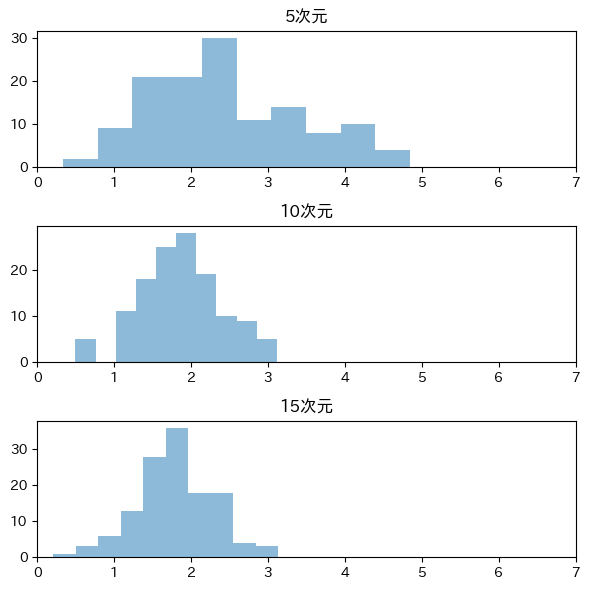

In [257]:
plt.rcParams["figure.figsize"] = (6, 6)
for index, dim in enumerate(dims):
    plt.subplot(3, 1, index+1)
    plt.hist(MAE_diff_est[dim], alpha=0.5)
    plt.title(f"{dim}次元")
    plt.xlim(0, 7)

plt.tight_layout()

In [258]:
df_diff_est = pd.DataFrame({'5次元':MAE_diff_est[5],'10次元':MAE_diff_est[10],'15次元':MAE_diff_est[15]})
df_diff_est.describe()

,5次元,10次元,15次元
count,130.000000,130.000000,130.000000
mean,2.443167,1.872101,1.798778
std,0.975856,0.527607,0.505622
min,0.336302,0.496055,0.207518
25%,1.692352,1.524850,1.523881
50%,2.313859,1.890585,1.793863
75%,3.106045,2.162781,2.094984
max,4.846033,3.116847,3.132842
